In [12]:
#Importing libraries 

import numpy as np 
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt


path = "../data/"  
database = path + 'database.sqlite'

In [13]:
#Connecting with database

conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [14]:
#Let's see the list of countries (country table)

countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [15]:
#Let's see the leagues and their corresponding country by joining 'League' and 'Country' tables.

leagues = pd.read_sql("""SELECT * 
                        FROM League
                        JOIN Country ON Country.id = League.country_id;""", conn)

leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


In [16]:
#Let's see the list of teams

teams = pd.read_sql("""SELECT *
                    FROM Team
                    ORDER BY team_long_name
                    LIMIT 10;""", conn)

teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA
5,11074,108893,111989,AC Arles-Avignon,ARL
6,49116,6493,1714,AC Bellinzona,BEL
7,26560,10217,650,ADO Den Haag,HAA
8,9537,8583,57,AJ Auxerre,AUX
9,9547,9829,69,AS Monaco,MON


In [17]:
#Now we are going to see specific columns from specific tables from Spain.
#We will rename some of the columns that have the same name.

Spain_matches = pd.read_sql("""SELECT Match.id,
                                    Country.name AS country_name,
                                    League.name AS league_name,
                                    season,
                                    stage,
                                    date,
                                    HT.team_long_name AS home_team,
                                    AT.team_long_name AS away_team,
                                    home_team_goal,
                                    away_team_goal
                                FROM Match
                                JOIN Country ON Country.id = Match.country_id
                                JOIN League ON League.id = Match.league_id
                                LEFT JOIN Team AS HT ON HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT ON AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Spain'
                                ORDER BY date
                                LIMIT 10;""", conn)

Spain_matches


,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,21518,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,Valencia CF,RCD Mallorca,3,0
1,21525,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,RCD Espanyol,Real Valladolid,1,0
2,21519,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CA Osasuna,Villarreal CF,1,1
3,21520,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,1
4,21521,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CD Numancia,FC Barcelona,1,0
5,21522,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Racing Santander,Sevilla FC,1,1
6,21523,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Sporting de Gijón,Getafe CF,1,2
7,21524,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Betis Balompié,RC Recreativo,0,1
8,21526,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Athletic Club de Bilbao,UD Almería,1,3
9,21527,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Atlético Madrid,Málaga CF,4,0


In [25]:
#We will group the data to different levels to examine. Let's look at the country-league-season level.
#We will use some aggregated functions to get some metrics
#Note - it is very important to use the same dimensions both in the SELECT, and in the GROUP BY. 
#Otherwise the output might be wrong

leagues_by_season = pd.read_sql("""SELECT Country.name AS country_name,
                                        League.name AS league_name,
                                        season,
                                        COUNT (DISTINCT stage) AS number_of_stages,
                                        COUNT (DISTINCT HT.team_long_name) AS number_of_teams,
                                        AVG(home_team_goal) AS avg_home_team_goals,
                                        AVG(away_team_goal) AS avg_away_team_goals,
                                        AVG(home_team_goal - away_team_goal) AS avg_goal_diff,
                                        AVG(home_team_goal + away_team_goal) AS avg_goals,
                                        SUM(home_team_goal + away_team_goal) AS total_goals
                                    FROM Match
                                    JOIN Country ON Country.id = Match.country_id
                                    JOIN League ON League.id = Match.league_id
                                    LEFT JOIN Team AS HT ON HT.team_api_id = Match.home_team_api_id
                                    LEFT JOIN Team AS AT ON AT.team_api_id = Match.away_team_api_id
                                    WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                    GROUP BY Country.name, League.name, season
                                    HAVING COUNT (DISTINCT stage) > 10
                                    ORDER BY Country.name, League.name, season DESC; """,conn)

leagues_by_season

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_goals,avg_away_team_goals,avg_goal_diff,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066
5,England,England Premier League,2010/2011,38,20,1.623684,1.173684,0.450000,2.797368,1063
6,England,England Premier League,2009/2010,38,20,1.697368,1.073684,0.623684,2.771053,1053
7,England,England Premier League,2008/2009,38,20,1.400000,1.078947,0.321053,2.478947,942
8,France,France Ligue 1,2015/2016,38,20,1.436842,1.089474,0.347368,2.526316,960
9,France,France Ligue 1,2014/2015,38,20,1.410526,1.081579,0.328947,2.492105,947


<AxesSubplot:title={'center':'Average goals per game over time'}>

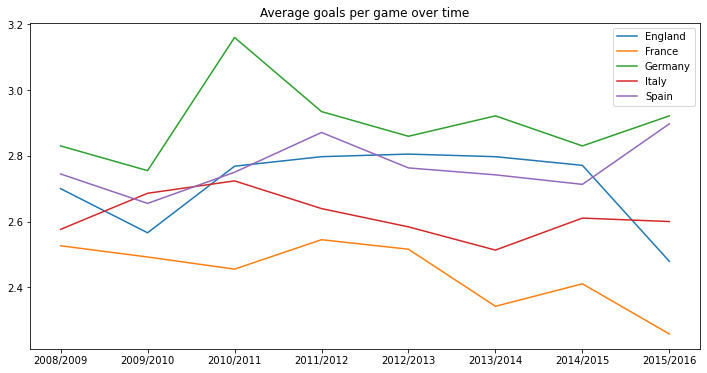

In [26]:
#Let's make a plot of the average goals per game over time

df = pd.DataFrame(index=np.sort(leagues_by_season['season'].unique()), columns = leagues_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leagues_by_season.loc[leagues_by_season['country_name'] == 'Germany', 'avg_goals'])
df.loc[:,'Spain'] = list(leagues_by_season.loc[leagues_by_season['country_name'] == 'Spain', 'avg_goals'])
df.loc[:,'France'] = list(leagues_by_season.loc[leagues_by_season['country_name'] == 'France', 'avg_goals'])
df.loc[:,'Italy'] = list(leagues_by_season.loc[leagues_by_season['country_name'] == 'Italy', 'avg_goals'])
df.loc[:,'England'] = list(leagues_by_season.loc[leagues_by_season['country_name'] == 'England', 'avg_goals'])

df.plot(figsize=(12,6), title = 'Average goals per game over time')


Practicing subquerying

In [27]:
#The problem is that while the first table holds one row for each player, the key in the second table is player+season, 
#so if we do a regular join, each player's basic details would appear as many times as this player appears in the 
#attributes table.
#We will use a subquery as using any other table, only that temporal, to group the attributes table, to a different key 
#- player level. In this case we will use average to comine all attributes to a single row.

players_height =  pd.read_sql("""SELECT CASE 
                                        WHEN ROUND(height) < 165 then 165
                                        WHEN ROUND(height) > 195 then 195
                                        ELSE ROUND(height) 
                                        END AS calc_height,
                                        COUNT(height) AS distribution,
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        AVG(weight) AS avg_weight
                                FROM PLAYER
                                LEFT JOIN (SELECT Player_Attributes.player_api_id, 
                                                avg(Player_Attributes.overall_rating) AS avg_overall_rating,
                                                avg(Player_Attributes.potential) AS avg_potential
                                            FROM Player_Attributes
                                            GROUP BY Player_Attributes.player_api_id)
                                            AS PA_Grouped ON PLAYER.player_api_id = PA_Grouped.player_api_id
                                GROUP BY calc_height
                                ORDER BY calc_height; """, conn)

players_height
                                            

,calc_height,distribution,avg_overall_rating,avg_potential,avg_weight
0,165.0,74,67.365543,73.327754,139.459459
1,168.0,118,67.500518,73.124182,144.127119
2,170.0,403,67.726903,73.379056,147.799007
3,173.0,530,66.980272,72.848746,152.824528
4,175.0,1188,66.805204,72.258774,156.111953
5,178.0,1489,66.367212,71.943339,160.665547
6,180.0,1388,66.419053,71.846394,165.261527
7,183.0,1954,66.634380,71.754555,170.167861
8,185.0,1278,66.928964,71.833475,174.636933
9,188.0,1305,67.094253,72.151949,179.278161


In [34]:
players_height.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   calc_height         13 non-null     float64
 1   distribution        13 non-null     int64  
 2   avg_overall_rating  13 non-null     float64
 3   avg_potential       13 non-null     float64
 4   avg_weight          13 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 648.0 bytes


<AxesSubplot:title={'center':'Potential vs Height'}, xlabel='calc_height'>

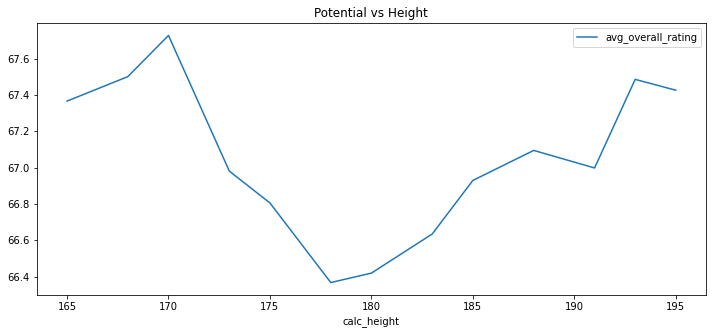

In [36]:
players_height.plot(kind='line', x='calc_height',y='avg_overall_rating',figsize=(12,5),title='Potential vs Height')